# Setting up my environment


In [1]:
#installing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Mount Google Drive



In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading and exploring data

In [34]:
#set the path to my Kaggle dataset
train_dir = '/content/drive/MyDrive/Kaggle/dataset/Train'
test_dir = '/content/drive/MyDrive/Kaggle/dataset/Test'

In [ ]:
print(os.listdir(train_dir))

In [ ]:
#count the number of images in each class (for apples)
fresh_count = len(os.listdir(os.path.join(data_dir, 'freshapples')))
stale_count = len(os.listdir(os.path.join(data_dir, 'rottenapples')))
print(f"Fresh images: {fresh_count}")
print(f"Stale images: {stale_count}")

# Data preparation



In [ ]:
#create a dataframe with image paths and labels
def create_dataframe(data_dir):
    image_paths = []
    labels = []
    for label in os.listdir(data_dir):
        for image_name in os.listdir(os.path.join(data_dir, label)):
            image_paths.append(os.path.join(data_dir, label, image_name))
            labels.append(label)
    return pd.DataFrame({'image_path': image_paths, 'label': labels})

df = create_dataframe(data_dir)

In [ ]:
#split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
#for non-binary classification
def create_dataframe(data_dir):
    image_paths = []
    labels = []
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        if os.path.isdir(category_path):
            for image_name in os.listdir(category_path):
                image_paths.append(os.path.join(category_path, image_name))
                labels.append(category)
    return pd.DataFrame({'image_path': image_paths, 'label': labels})

# Create DataFrames for train and test sets
train_df = create_dataframe('/content/drive/MyDrive/Kaggle/dataset/Train')
test_df = create_dataframe('/content/drive/MyDrive/Kaggle/dataset/Test')

# Get the number of classes
num_classes = len(train_df['label'].unique())
print(f"Number of classes: {num_classes}")

Number of classes: 16


In [ ]:
def reduce_dataset(df, sample_size):
    return df.groupby('label').apply(lambda x: x.sample(min(len(x), sample_size))).reset_index(drop=True)

# Reduce the training dataset
sample_size_per_class = 1000  # Adjust this value based on your needs
reduced_train_df = reduce_dataset(train_df, sample_size_per_class)
reduced_test_df = reduce_dataset(test_df, sample_size_per_class)


In [ ]:
print("Original dataset size:", len(train_df))
print("Reduced dataset size:", len(reduced_train_df))
print(reduced_train_df['label'].value_counts())

print("Original dataset size:", len(test_df))
print("Reduced dataset size:", len(reduced_test_df))
print(reduced_test_df['label'].value_counts())

In [40]:
# Split train data into train and validation
train_df, val_df = train_test_split(reduced_train_df, test_size=0.2, stratify=reduced_train_df['label'], random_state=42)

# Data augmentation and preprocessing with ImageDataGenerator

In [ ]:
#settting up data augmentation and preprocessing using ImageDataGenerator
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


In [ ]:
#for non-binary classification
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Build the CNN Model

In [ ]:
#creating a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
#for non-binary classification
num_classes = len(reduced_train_df['label'].unique())


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Changed to num_classes and softmax
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Changed to categorical_crossentropy
              metrics=['accuracy'])

model.summary()

# Training the Model

In [ ]:
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 27/295 ━━━━━━━━━━━━━━━━━━━━ 1:31:32 20s/step - accuracy: 0.0902 - loss: 3.1280

# Evaluate the Model

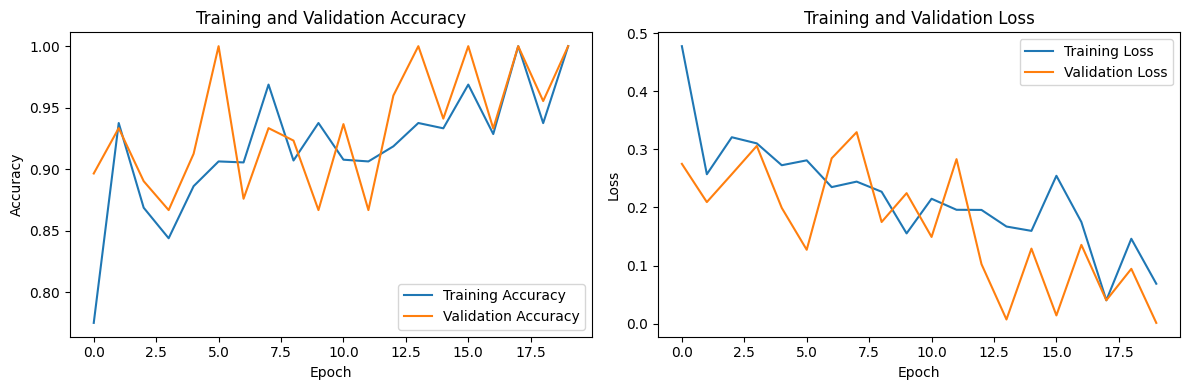

In [ ]:
#evaluation (apples only)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

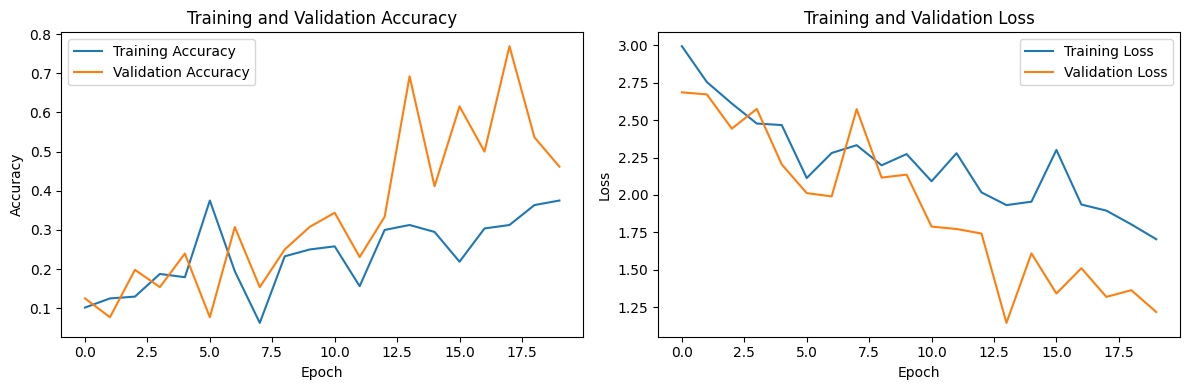

In [33]:
#for the multi-classification
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#Implementing the Model

In [ ]:
def predict_image(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  img_array /= 255.0

  predictions = model.predict(img_array)
  class_names = ['freshapples', 'rottenapples']
  predicted_class = class_names[int(round(predictions[0][0]))]
  confidence = predictions[0][0] if predicted_class == 'freshapples' else 1 - predictions[0][0]

  return predicted_class, confidence

#example
image_path = '/path/to/test/image.jpg'
predicted_class, confidence = predict_image(image_path)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

In [ ]:
#for non-binary classification
def predict_image(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  img_array /= 255.0

  predictions = model.predict(img_array)
  class_names = list(train_generator.class_indices.keys())
  predicted_class = class_names[np.argmax(predictions)]
  confidence = np.max(predictions)

  return predicted_class, confidence

# Example usage
image_path = '/path/to/test/image.jpg'
predicted_class, confidence = predict_image(image_path, model)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")